<a href="https://colab.research.google.com/github/Takuma-Furukawa/MEA_tutorials/blob/main/spike_detection_and_sorting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Spike Detection & Spike Sorting Tutorial

## About
* First (section 1), we use the Python library called `MEArec` to generate recording data with ground truth.
* In section 2, we observe how raw signal can be preprocessed with multiple filters.
* In section 3, we implement spike detection with simple thresholds.
* In section 4, we compare multiple clustering methods for spike sorting.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


If you can't mount your Drive, you can specify the `/content/` folder, but note that these files will be deleted after the session.

In [2]:
datadir = '/content/drive/MyDrive/'  # edit here: simulated recordings will be saved here

## 1. generate recording data with MEArec

In [3]:
!pip install MEArec -q
!pip install neuron -q
!pip install LFPy>=2.2 -q

In [4]:
import MEArec as mr
import numpy as np
import matplotlib.pylab as plt

### 1.1 generate simulation data (once executed, this section can be skipped from next time)

In [3]:
!mearec available-probes

Neuronexus-32 ---------- Neuronexus A1x32-Poly3-5mm-25s-177-CM32 probe. 32 circular contacts in 3 staggered columns.

Neuropixels-128 ---------- Neuropixels probe. 128 square contacts in 4 staggered columns.

Neuropixels-24 ---------- Neuropixels probe. 24 square contacts in 4 staggered columns.

Neuropixels-384 ---------- Neuropixels probe. 384 square contacts in 4 staggered columns.

Neuropixels-64 ---------- Neuropixels probe. 64 square contacts in 4 staggered columns.

Neuroseeker-128 ---------- Neuroseeker probe. 128 square contacts in 4 columns.

SqMEA-10-15 ---------- Square MEA. 100 square contacts in 10x10 matrix configuration with 15um pitch.

SqMEA-15-10 ---------- Square MEA. 225 square contacts in 15x15 matrix configuration with 10um pitch.

SqMEA-5-30 ---------- Square MEA. 25 square contacts in 5x5 matrix configuration with 30um pitch.

SqMEA-6-25 ---------- Square MEA. 36 square contacts in 6x6 matrix configuration with 25um pitch.

SqMEA-7-20 ---------- Square MEA. 49 

In [4]:
# this will take 5-10 minutes

# generate templates
templates_params = mr.get_default_templates_params() 
cell_models_folder = mr.get_default_cell_models_folder() 
templates_params['probe'] = 'SqMEA-10-15'
templates_params['n'] = 10
templates_params['seed'] = 0
tempgen = mr.gen_templates(cell_models_folder=cell_models_folder, params=templates_params)

Compiling NEURON models
Setting n_jobs to 2 CPUs
Running with 2 jobs



Simulation time: 405.47797870635986





In [6]:
# generate recordings 
recordings_params = mr.get_default_recordings_params()

recordings_params["recordings"]["filter"] = False
recordings_params["recordings"]["noise_level"] = 5

recordings_params["spiketrains"]["n_exc"] = 4 
recordings_params["spiketrains"]["n_inh"] = 2 
recordings_params["spiketrains"]["duration"] = 10 

recordings_params["seeds"]["spiketrains"] = 0 
recordings_params["seeds"]["templates"] = 1 
recordings_params["seeds"]["noise"] = 2 

recgen = mr.gen_recordings(params=recordings_params, tempgen=tempgen)

Spiketrains seed:  0
Noise Level  5
Templates selection seed:  1
Selecting cells
Padding template edges
Elapsed pad time: 0.9952182769775391
Creating time jittering
Elapsed jitter time: 1.3197648525238037
Computing spike train SNR
Adding spiketrain annotations
Convolution seed:  5763
Electrode modulaton
Adding noise
Noise seed:  2
Elapsed time:  6.188241779000009


In [9]:
# save the simulation results in your Drive
mr.save_template_generator(tempgen, datadir + 'template.h5')
mr.save_recording_generator(recgen, datadir + 'recordings.h5')


Saved  templates in /content/drive/MyDrive/template.h5 



### 1.2 load and visualize simulation results

In [5]:
tempgen = mr.load_templates(datadir + 'template.h5')
recgen = mr.load_recordings(datadir + 'recordings.h5')

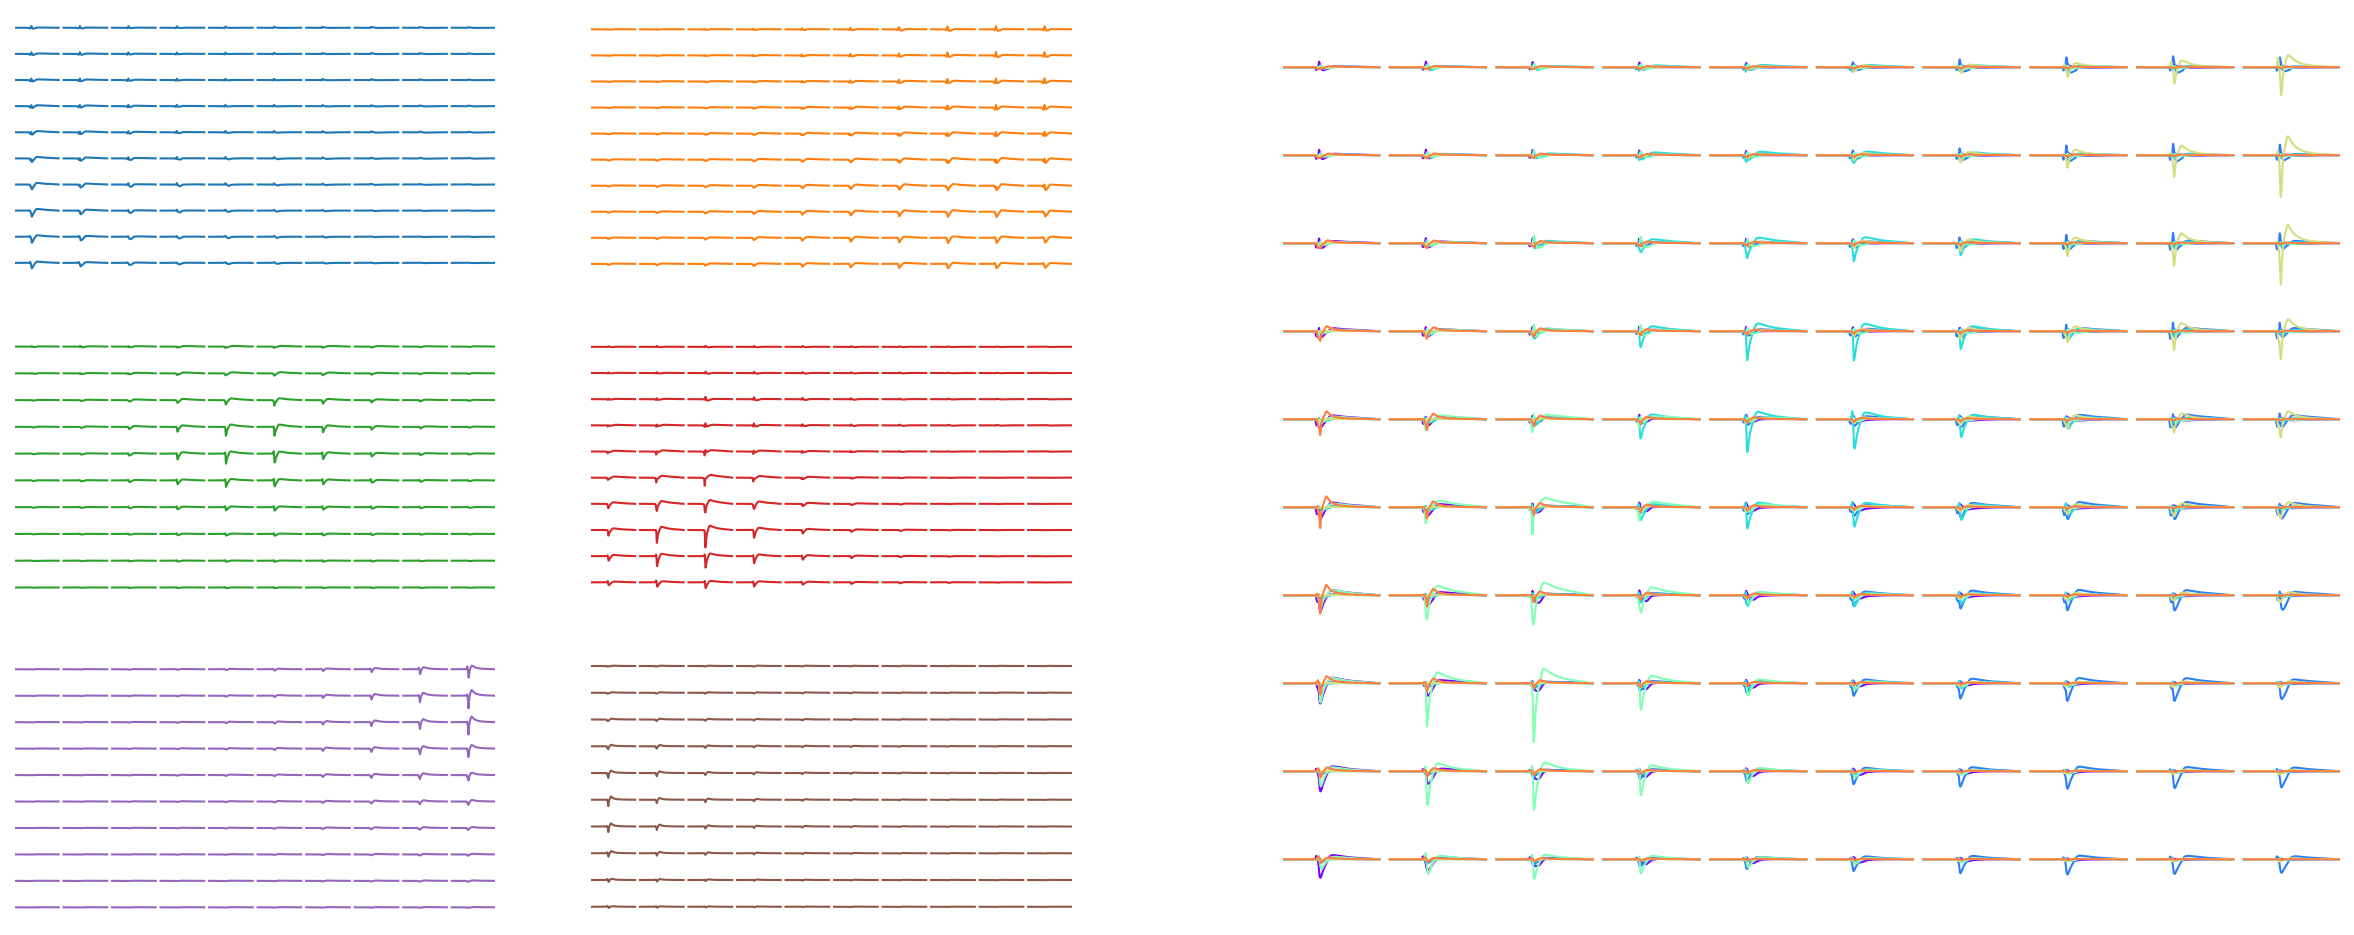

In [6]:
# plot templates
fig, axes = plt.subplots(1, 2, figsize=(20, 8), dpi=150)
mr.plot_templates(recgen, single_axes=False, ncols=2, ax=axes[0])
mr.plot_templates(recgen, single_axes=True, cmap='rainbow', ax=axes[1])
plt.show()

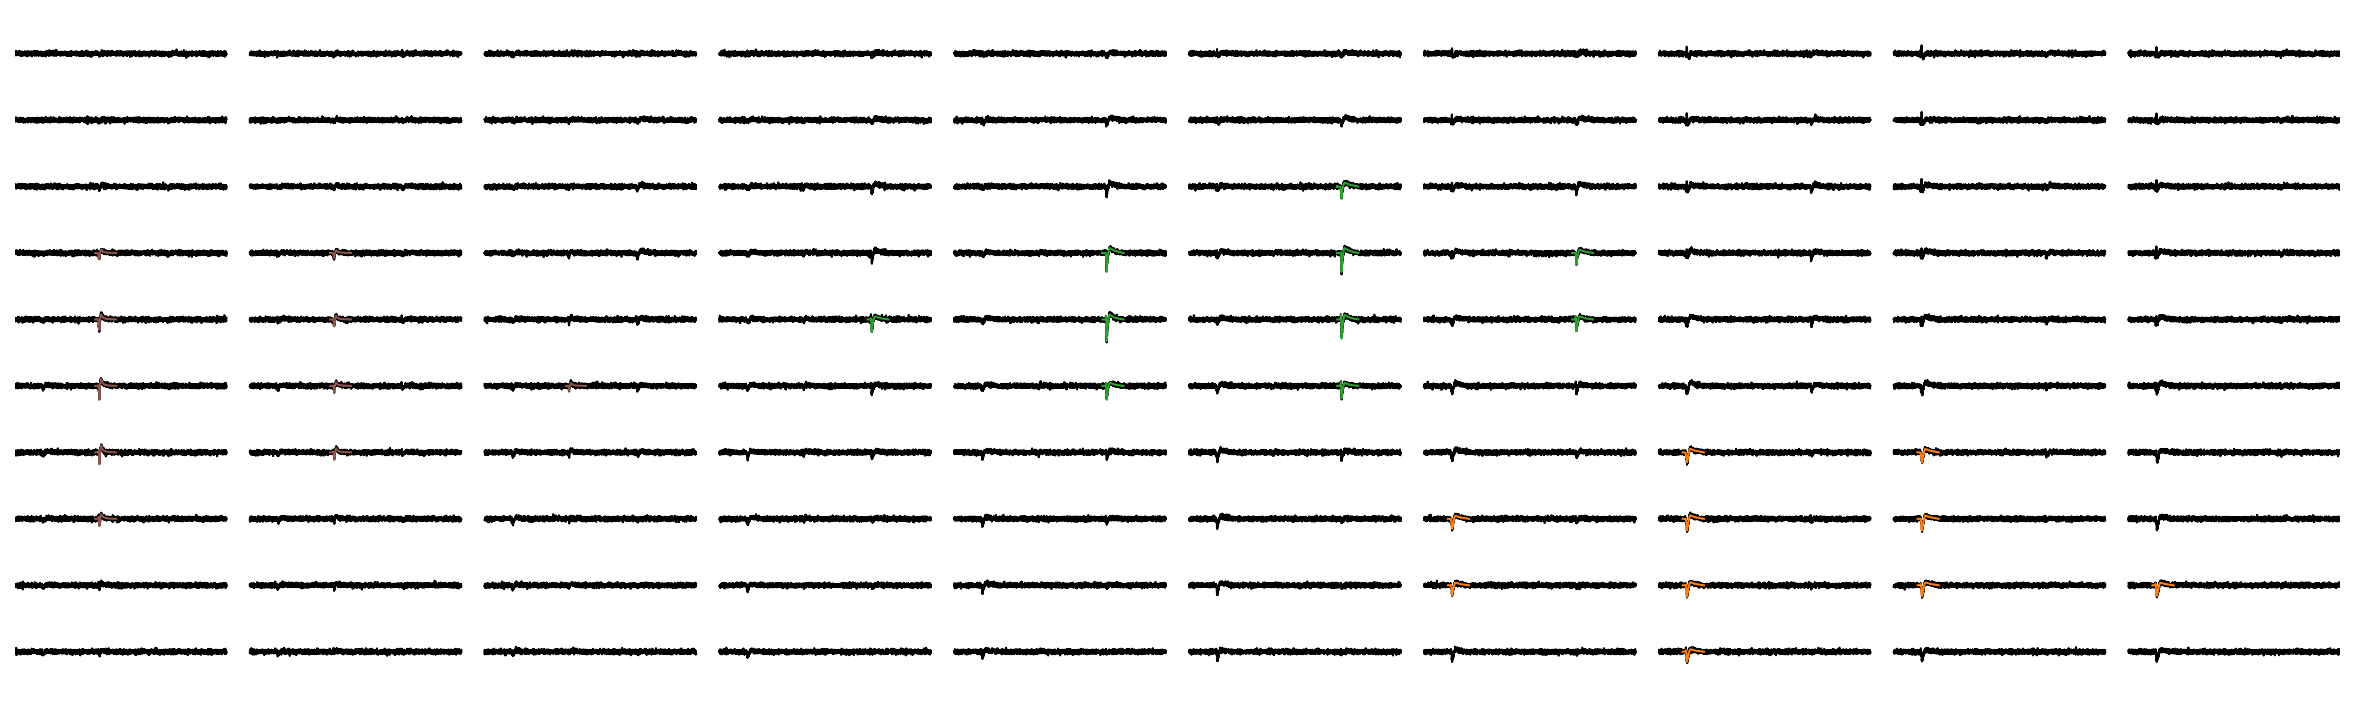

In [7]:
fig, ax = plt.subplots(figsize=(20, 6), dpi=150)
mr.plot_recordings(recgen, start_time=3.00, end_time=3.10, overlay_templates=True, ax=ax, max_channels_per_template=10)
plt.show()

max electrode:  2
max electrode:  82
max electrode:  45
max electrode:  22
max electrode:  98
max electrode:  4


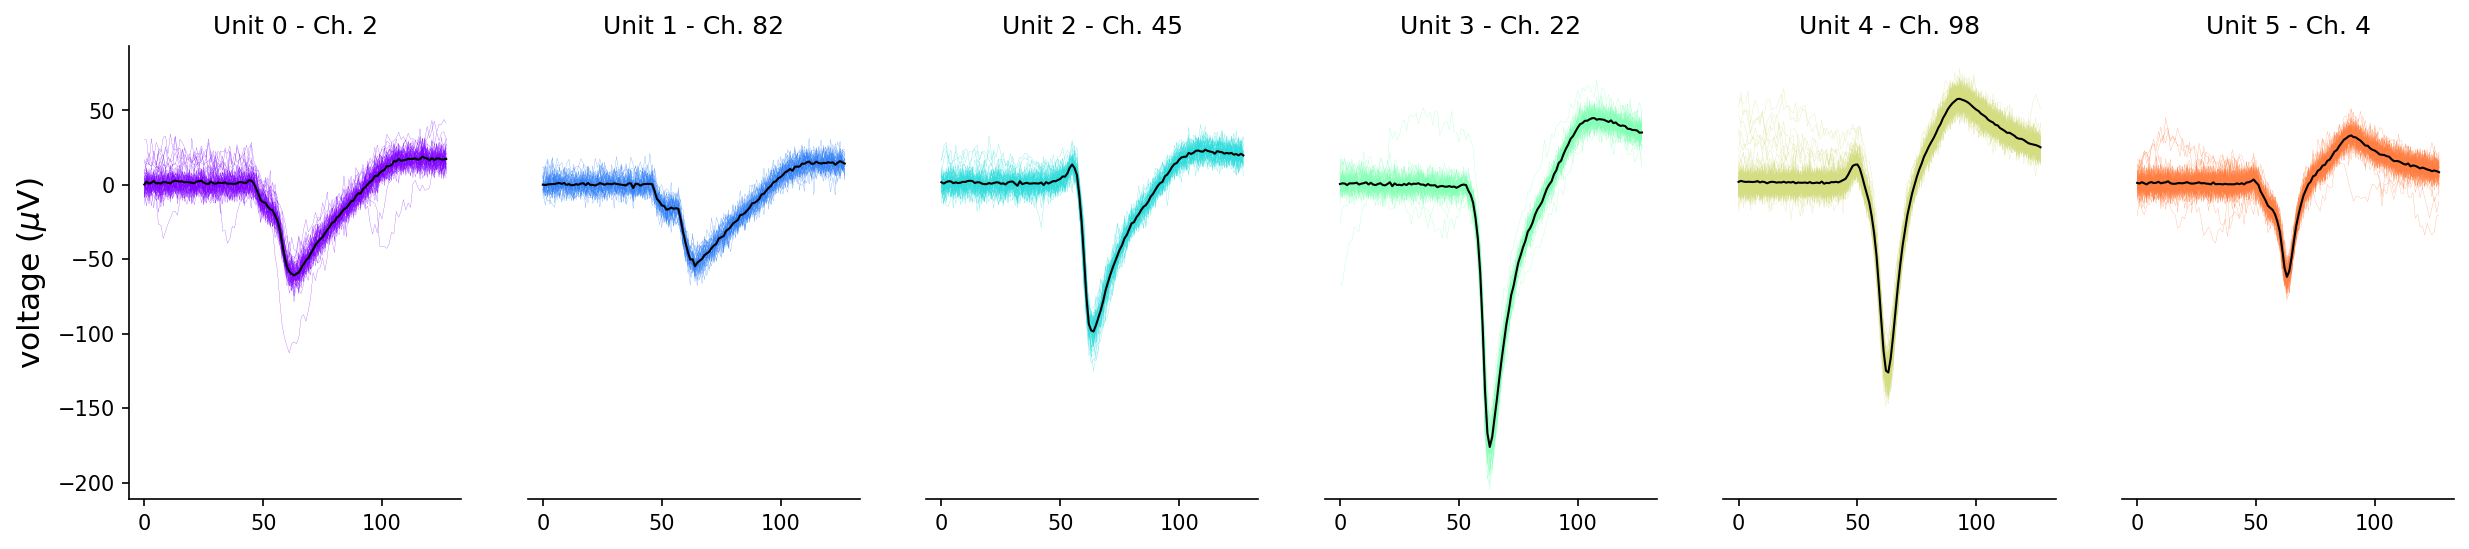

In [8]:
fig, ax = plt.subplots(figsize=(20, 4), dpi=150)
mr.plot_waveforms(recgen, electrode='max', cmap='rainbow', ax=ax)
plt.show()

## 2. pre-processing (filtering)

In [9]:
from scipy.signal import butter, lfilter, filtfilt

In [10]:
# filter functions
def butter_bandpass(lowcut, highcut, fs, order):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order, zero_phase):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    
    if zero_phase:
        y = filtfilt(b, a, data)  # zero-phase filter
    else:
        y = lfilter(b, a, data)  # ordinary IIR filter
    return y

def sig_filter(data, lowcut, highcut, fs, order=3, zero_phase=True):
    """
    :param data: (n_samples, ) or (n_channel, n_samples) array of signal
    :param lowcut: lowcut frequency [Hz]
    :param highcut: highcut frequency [Hz]
    :param fs: sampling rate
    :param order: butterworth order
    :param zero_phase: if True, apply zero-phase filter
    """
    if data.ndim == 1:
        data = np.atleast_2d(data)
        
    data_av = (data - np.mean(data, axis=1).reshape(-1, 1))
    data_filt = butter_bandpass_filter(data=data_av, lowcut=lowcut, highcut=highcut, 
                                       fs=fs, order=order, zero_phase=zero_phase)
    return data_filt

In [11]:
# plot functions
def plot_sig(ax, sig, start, end, fs=32000, title=None, xlabel=None, ylabel=None):
    x = np.arange(fs * start, fs * end).astype(int)  # signal index
    ax.plot(x / fs, sig[x])
    
    if title is not None:
        ax.set_title(title)
    if xlabel is not None:
        ax.set_xlabel(xlabel)
    if ylabel is not None:
        ax.set_ylabel(ylabel)
        
    ax.set_xlim(start, end)    
    return ax

def plot_neuron_traces(ax, recgen, ch, start, end, fs=32000, title=None, xlabel=None, ylabel=None):
    x = np.arange(fs * start, fs * end).astype(int)  # signal index
    
    for i, neuron in enumerate(recgen.spiketrains):
        sig_0 = np.zeros(len(x))  # baseline
        spikes = neuron.times

        for t in spikes[(start <= spikes) & (spikes <= end)]:
            template = recgen.templates[i, 0, ch, :]
            idx_start = int((np.float64(t) - start) * fs) - np.argmin(template)
            idx_end = idx_start + len(template)
            
            if idx_start < 0:
                sig_0[:idx_end] += template[-idx_start:]
            elif idx_end > len(x):
                sig_0[idx_start:] += template[:len(x)-idx_end]
            else:
                sig_0[idx_start:idx_end] += template

        ax.plot(x / fs, sig_0, label='unit {}'.format(i))
    
    if title is not None:
        ax.set_title(title)
    if xlabel is not None:
        ax.set_xlabel(xlabel)
    if ylabel is not None:
        ax.set_ylabel(ylabel)
        
    ax.set_xlim(start, end)
    return ax

In [12]:
ch = 0  # channel idx
fs = 32000  # sampling rate

sig = recgen.recordings[:, ch]
sig_iir = sig_filter(data=sig, fs=fs, lowcut=500, highcut=3000, zero_phase=False)[0]  # ordinary IIR filter
sig_filtfilt = sig_filter(data=sig, fs=fs, lowcut=500, highcut=3000, zero_phase=True)[0]  # zero-phase filter

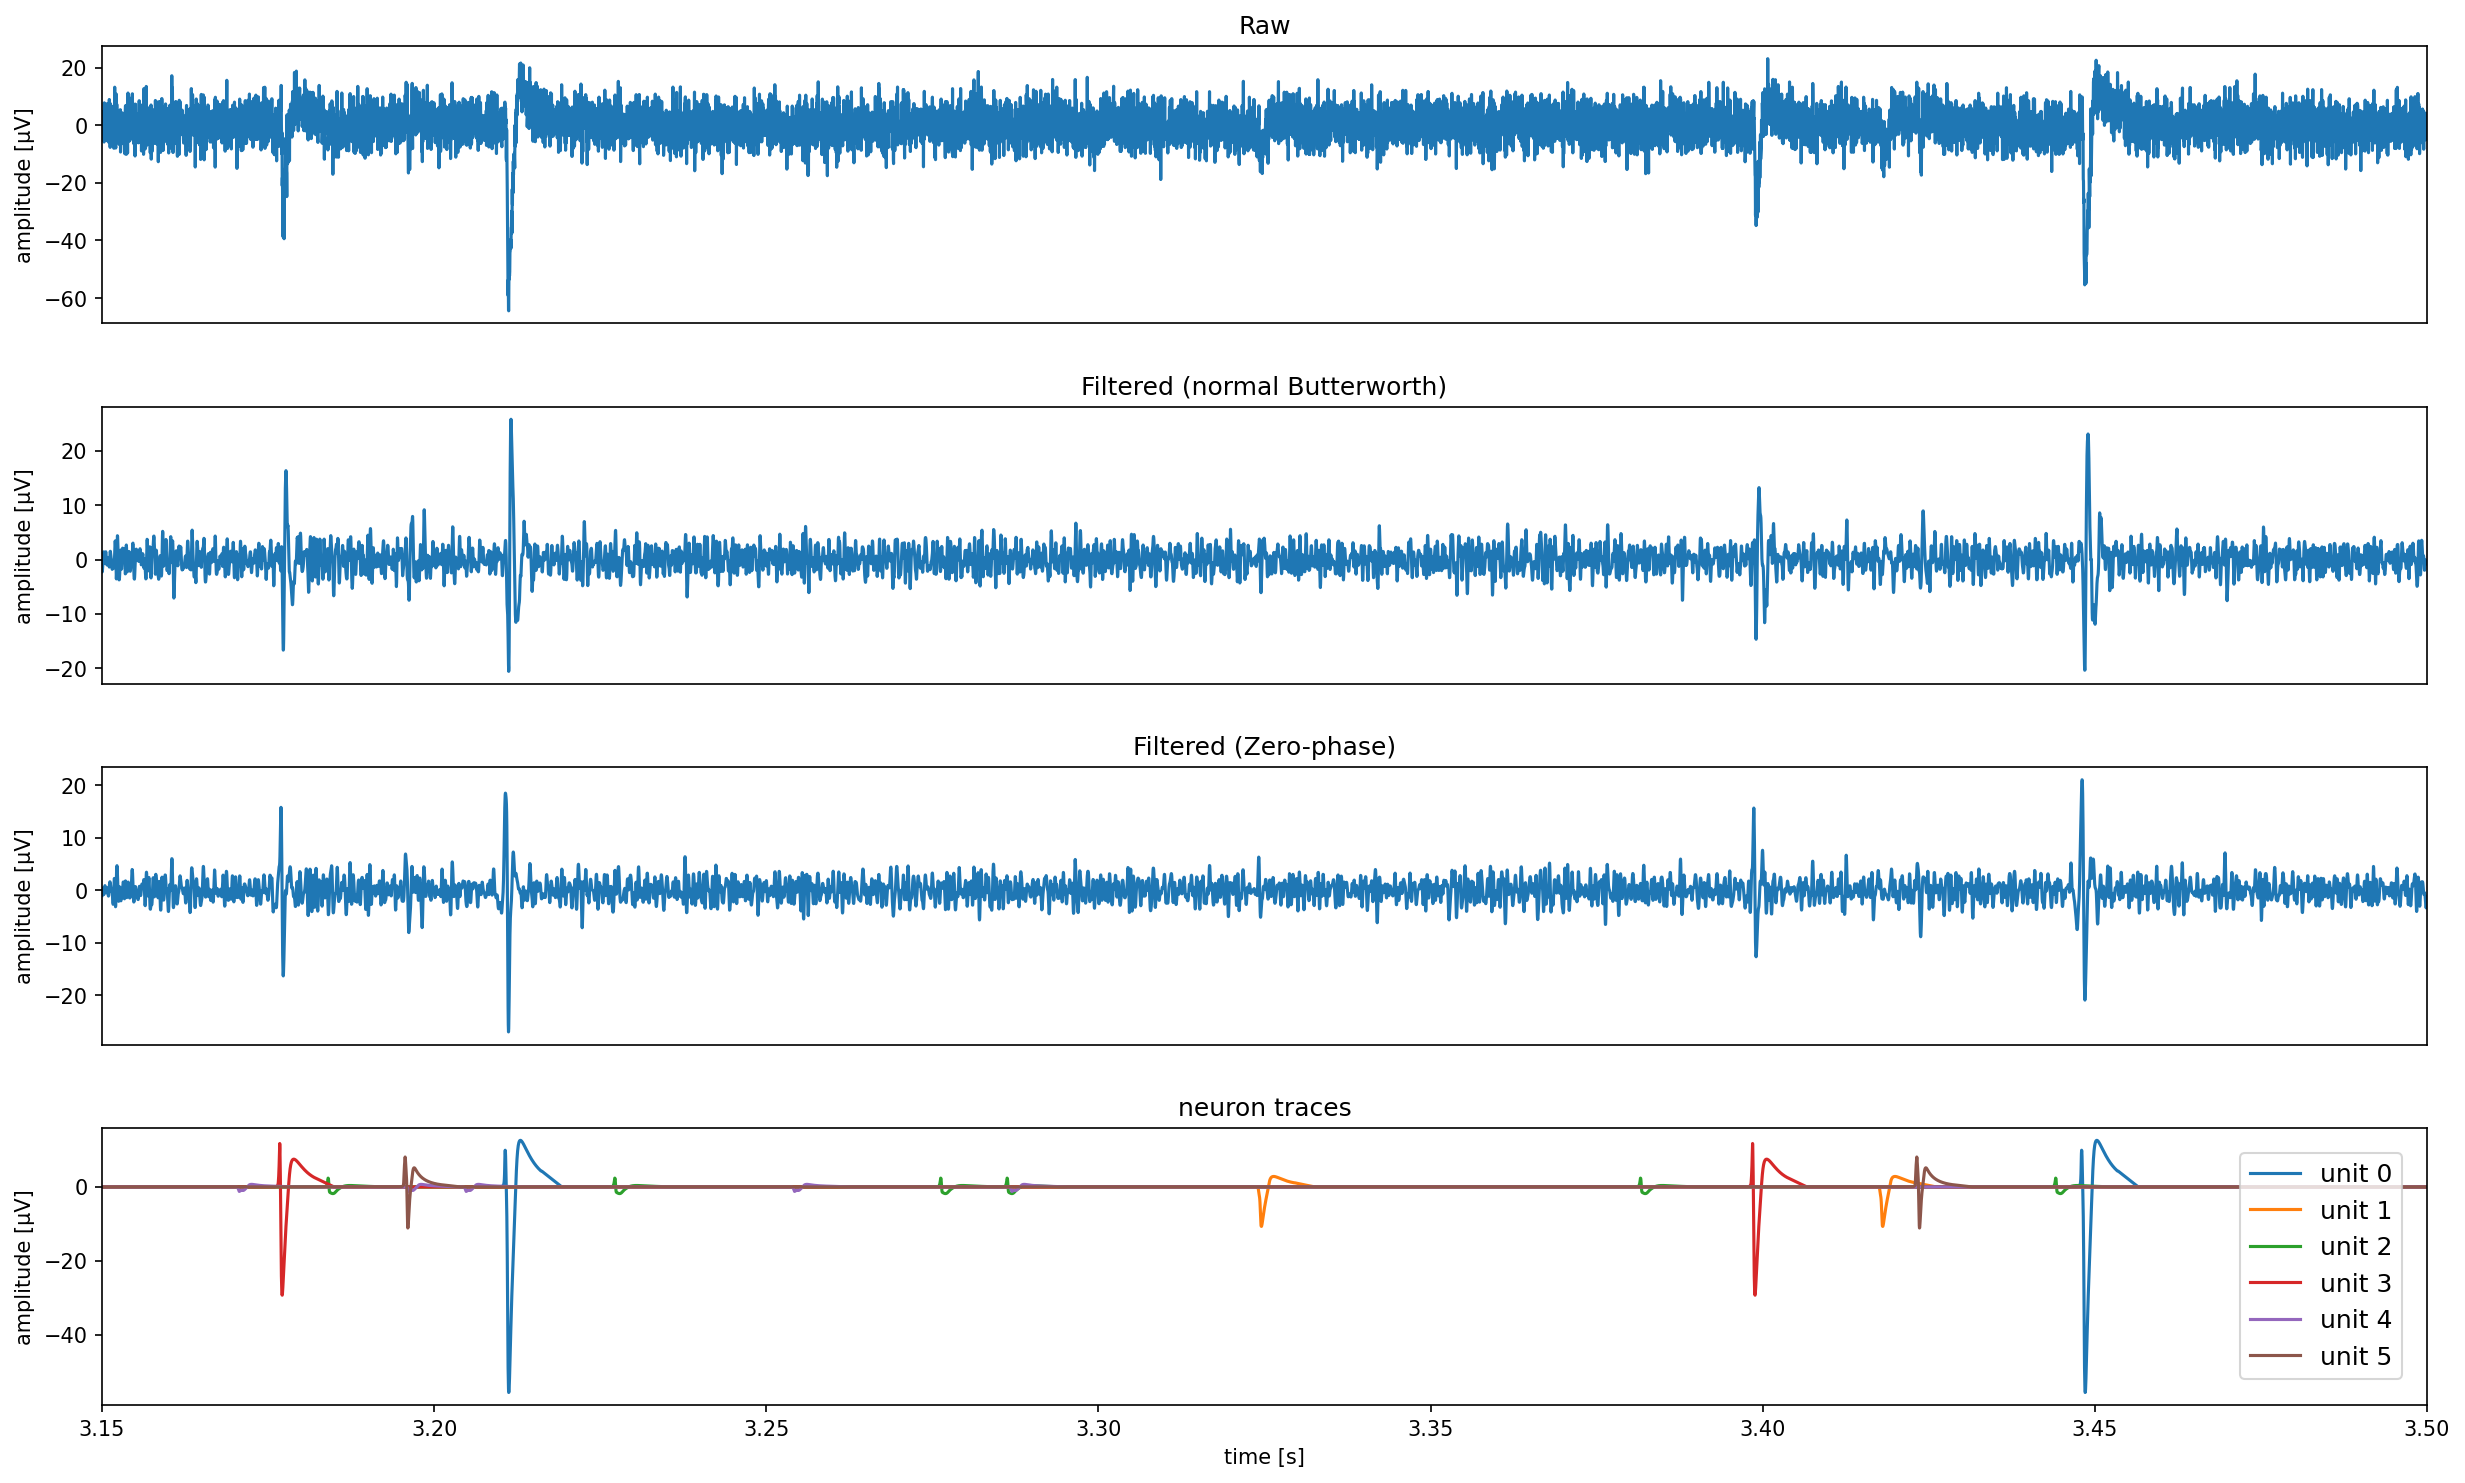

In [13]:
start, end = 3.15, 3.50
plt.figure(figsize=(20, 12), dpi=150)

# plot 1
ax1 = plt.subplot(4, 1, 1)
ax1 = plot_sig(ax=ax1, sig=sig, start=start, end=end, title='Raw', ylabel='amplitude [μV]')
ax1.set_xticks([])

# plot 2
ax2 = plt.subplot(4, 1, 2)
ax2 = plot_sig(ax=ax2, sig=sig_iir, start=start, end=end, title='Filtered (normal Butterworth)', ylabel='amplitude [μV]')
ax2.set_xticks([])

# plot 3
ax3 = plt.subplot(4, 1, 3)
ax3 = plot_sig(ax=ax3, sig=sig_filtfilt, start=start, end=end, title='Filtered (Zero-phase)', ylabel='amplitude [μV]')
ax3.set_xticks([])

# plot 4
ax4 = plt.subplot(4, 1, 4)
ax4 = plot_neuron_traces(ax=ax4, recgen=recgen, ch=ch, start=start, end=end, title='neuron traces', 
                         xlabel='time [s]', ylabel='amplitude [μV]')
ax4.legend(bbox_to_anchor=(1, 1), loc='upper right', borderaxespad=1, fontsize=12)

# show
plt.subplots_adjust(wspace=0.4, hspace=0.3)
plt.show()

## 3. spike detection

In [16]:
from scipy import stats
from scipy.signal import find_peaks

In [15]:
def peak_detection(sig, thr, distance=100):
    peaks, _ = find_peaks(-1 * sig, height=thr, distance=distance)
    return peaks

In [17]:
# set thresholds for peak detection
n_std = 5
n_mad = 6

thr_std = np.std(sig_filtfilt) * n_std
thr_mad = stats.median_abs_deviation(sig_filtfilt) * n_mad

print('{} s.d.: {:.2f}'.format(n_std, thr_std))
print('{} MAD: {:.2f}'.format(n_mad, thr_mad))

5 s.d.: 13.02
6 MAD: 7.90


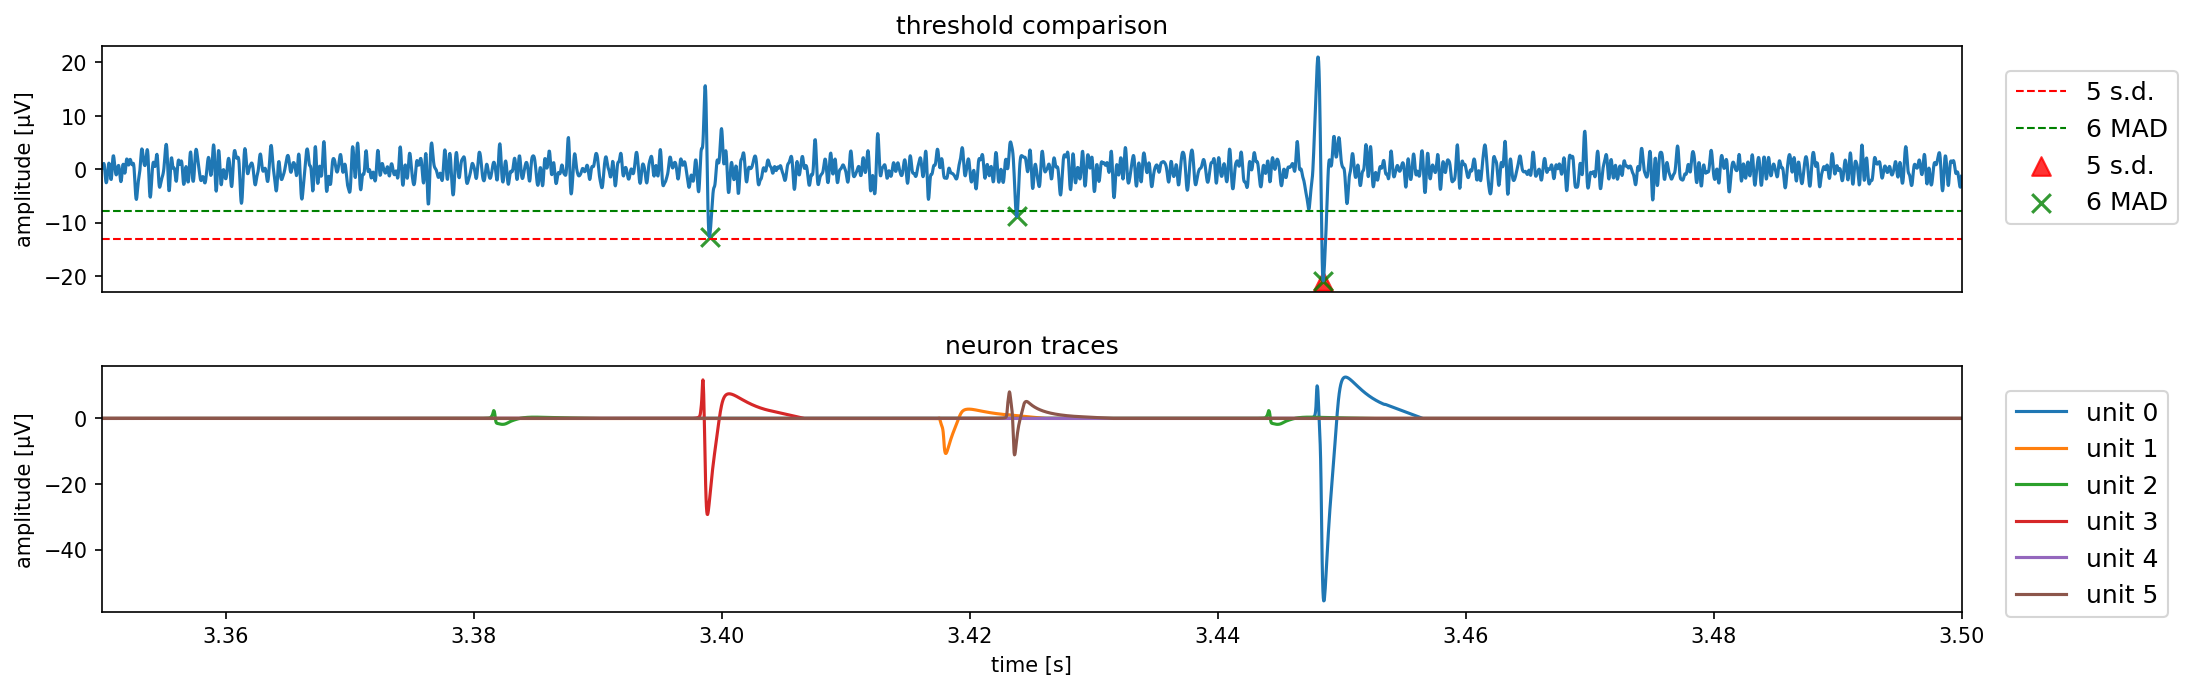

In [18]:
start, end = 3.35, 3.50  # sec
x = np.arange(fs * start, fs * end).astype(int)  # data range

plt.figure(figsize=(16, 5), dpi=150)

# plot 1
ax1 = plt.subplot(2, 1, 1)
ax1 = plot_sig(ax=ax1, sig=sig_filtfilt, start=start, end=end, title='threshold comparison', ylabel='amplitude [μV]')
ax1.set_xticks([])

## plot peaks
peaks_std = peak_detection(sig=sig_filtfilt[x], thr=thr_std)
peaks_mad = peak_detection(sig=sig_filtfilt[x], thr=thr_mad)
ax1.scatter(x=x[peaks_std] / fs, y=sig_filtfilt[x][peaks_std], s=80, alpha=0.8, marker='^', c='red', label='{} s.d.'.format(n_std))
ax1.scatter(x=x[peaks_mad] / fs, y=sig_filtfilt[x][peaks_mad], s=80, alpha=0.8, marker='x', c='green', label='{} MAD'.format(n_mad))

## plot thresholds
ax1.axhline(y=-thr_std, xmin=0.0, xmax=1.0, label='{} s.d.'.format(n_std), color='red', linestyle='dashed', linewidth=1)
ax1.axhline(y=-thr_mad, xmin=0.0, xmax=1.0, label='{} MAD'.format(n_mad), color='green', linestyle='dashed', linewidth=1)
ax1.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=1, fontsize=12)

# plot 2
ax2 = plt.subplot(2, 1, 2)
ax2 = plot_neuron_traces(ax=ax2, recgen=recgen, ch=ch, start=start, end=end, title='neuron traces', 
                         xlabel='time [s]', ylabel='amplitude [μV]')
ax2.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=1, fontsize=12)

# show
plt.subplots_adjust(wspace=0.4, hspace=0.3)
plt.show()

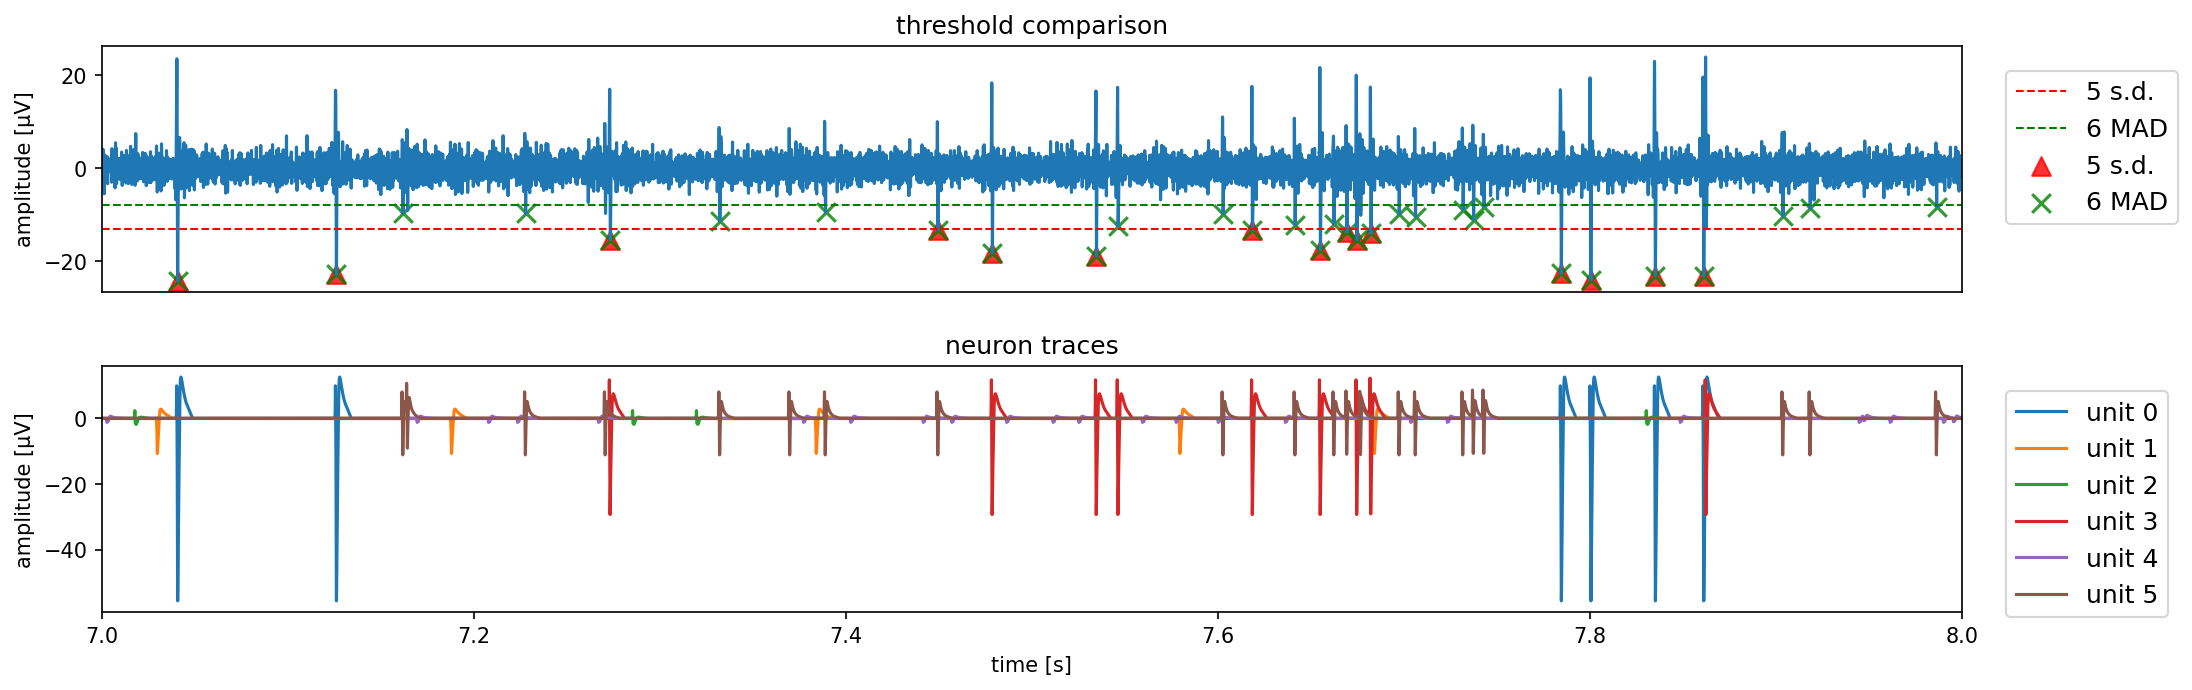

In [19]:
start, end = 7.00, 8.00  # sec
x = np.arange(fs * start, fs * end).astype(int)  # data range

plt.figure(figsize=(16, 5), dpi=150)

# plot 1
ax1 = plt.subplot(2, 1, 1)
ax1 = plot_sig(ax=ax1, sig=sig_filtfilt, start=start, end=end, title='threshold comparison', ylabel='amplitude [μV]')
ax1.set_xticks([])

## plot peaks
peaks_std = peak_detection(sig=sig_filtfilt[x], thr=thr_std)
peaks_mad = peak_detection(sig=sig_filtfilt[x], thr=thr_mad)
ax1.scatter(x=x[peaks_std] / fs, y=sig_filtfilt[x][peaks_std], s=80, alpha=0.8, marker='^', c='red', label='{} s.d.'.format(n_std))
ax1.scatter(x=x[peaks_mad] / fs, y=sig_filtfilt[x][peaks_mad], s=80, alpha=0.8, marker='x', c='green', label='{} MAD'.format(n_mad))

## plot thresholds
ax1.axhline(y=-thr_std, xmin=0.0, xmax=1.0, label='{} s.d.'.format(n_std), color='red', linestyle='dashed', linewidth=1)
ax1.axhline(y=-thr_mad, xmin=0.0, xmax=1.0, label='{} MAD'.format(n_mad), color='green', linestyle='dashed', linewidth=1)
ax1.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=1, fontsize=12)

# plot 2
ax2 = plt.subplot(2, 1, 2)
ax2 = plot_neuron_traces(ax=ax2, recgen=recgen, ch=ch, start=start, end=end, title='neuron traces', 
                         xlabel='time [s]', ylabel='amplitude [μV]')
ax2.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=1, fontsize=12)

# show
plt.subplots_adjust(wspace=0.4, hspace=0.3)
plt.show()

## 4. spike sorting

In [20]:
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN, KMeans
from sklearn.mixture import GaussianMixture

In [21]:
def extract_spike_waveforms(sig, peaks, t_pre, t_post, fs=32000):
    """
    extract signal in the range of [t_spike - t_pre, t_spike + t_post] (msec)
    """
    n_pre = int(fs * t_pre / 1000)
    n_post = int(fs * t_post / 1000)
    peaks_ = peaks[(n_pre <= peaks) & (peaks <= len(sig) - n_post)]  # waveforms must be within data range
    waveforms = np.array([sig[peak - n_pre : peak + n_post] for peak in peaks_])
    return waveforms

### 4.1 sorting with single channel

In [45]:
n_mad = 6
thr_mad = stats.median_abs_deviation(sig_filtfilt) * n_mad
peaks = peak_detection(sig=sig_filtfilt, thr=thr_mad)
spike_waveforms = extract_spike_waveforms(sig=sig_filtfilt, peaks=peaks, t_pre=1, t_post=2)

In [46]:
pca = PCA(n_components=2, random_state=0)
pca.fit(spike_waveforms.T)
res_pca = pca.components_.T

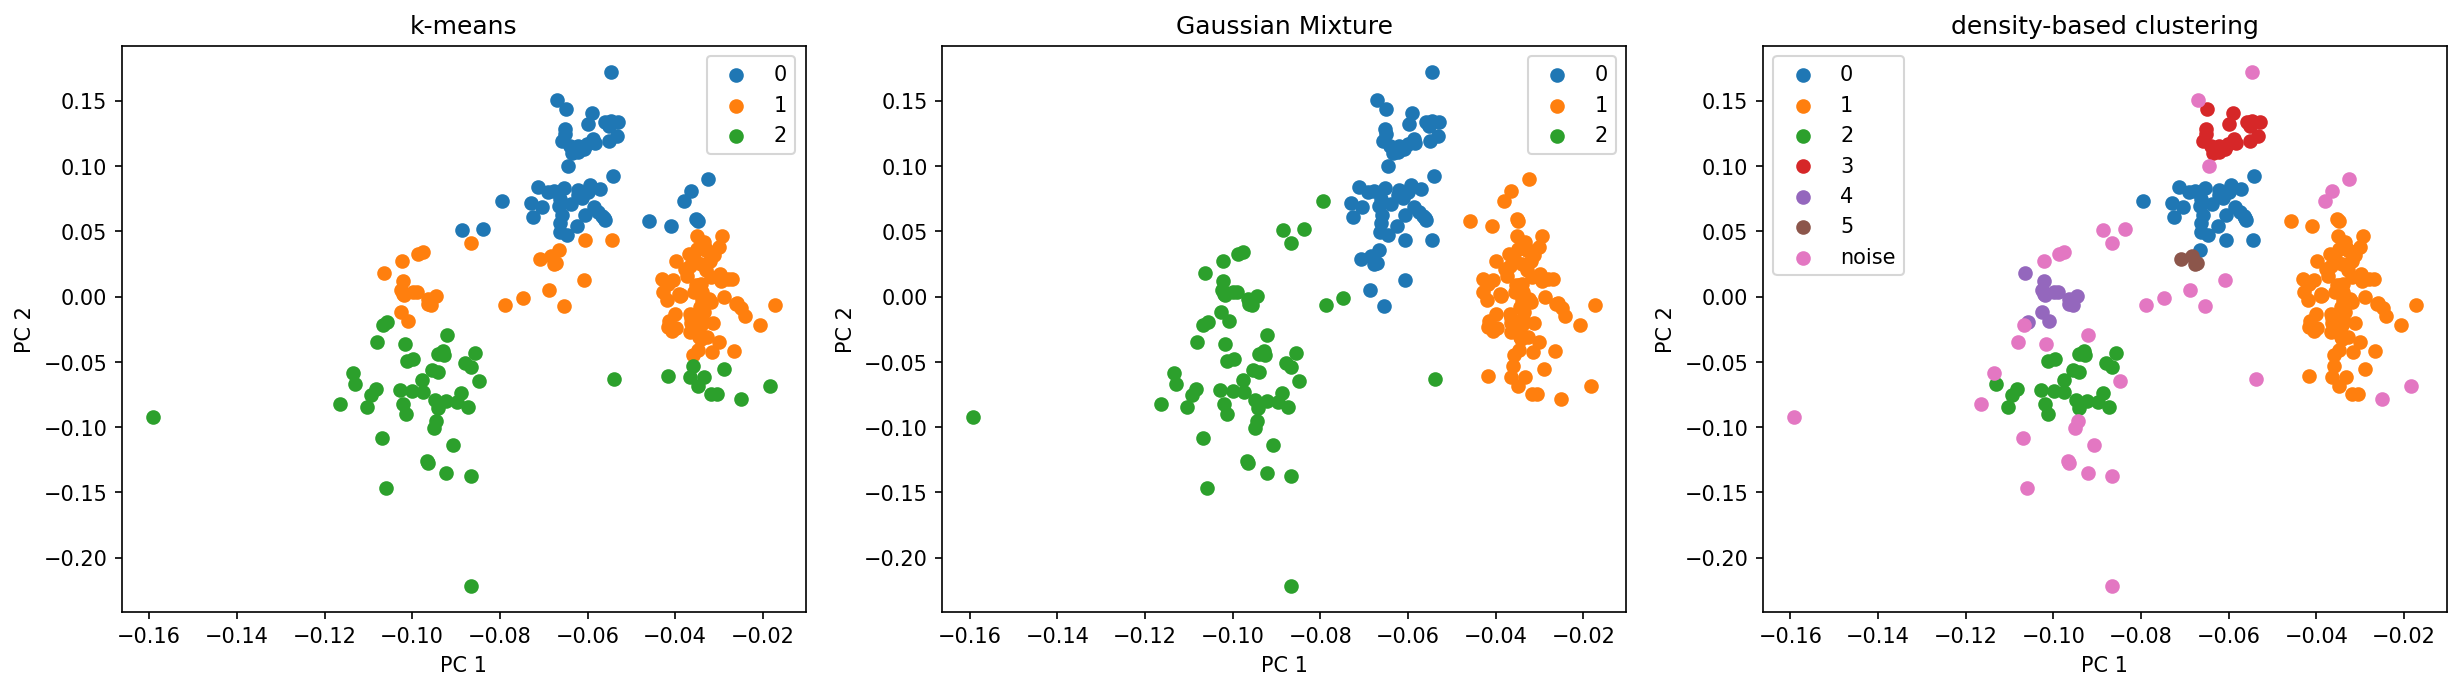

In [48]:
n_clusters = 3
fig, axes = plt.subplots(1, 3, figsize=(20, 5), dpi=150)

# k-means
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(res_pca)
labels = kmeans.labels_

for i in range(n_clusters):
    idx = (labels == i)
    axes[0].scatter(x=res_pca[:, 0][idx], y=res_pca[:, 1][idx], label=i)

axes[0].set_title('k-means')
axes[0].set_xlabel('PC 1')
axes[0].set_ylabel('PC 2')
axes[0].legend()

# Gausian Mixture
gm = GaussianMixture(n_components=n_clusters, random_state=0).fit(res_pca)
labels = gm.predict(res_pca)

for i in range(n_clusters):
    idx = (labels == i)
    axes[1].scatter(x=res_pca[:, 0][idx], y=res_pca[:, 1][idx], label=i)

axes[1].set_title('Gaussian Mixture')
axes[1].set_xlabel('PC 1')
axes[1].set_ylabel('PC 2')
axes[1].legend()

# density-based clustering
clustering = DBSCAN(eps=0.01, min_samples=5).fit(res_pca)
labels = clustering.labels_
n_clusters = np.max(labels) + 1

for i in range(n_clusters):
    idx = (labels == i)
    axes[2].scatter(x=res_pca[:, 0][idx], y=res_pca[:, 1][idx], label=i)

# in DBSCAN, outliers are labeled as -1
idx = labels == -1
axes[2].scatter(x=res_pca[:, 0][idx], y=res_pca[:, 1][idx], label='noise')

axes[2].set_title('density-based clustering')
axes[2].set_xlabel('PC 1')
axes[2].set_ylabel('PC 2')
axes[2].legend()

plt.show()

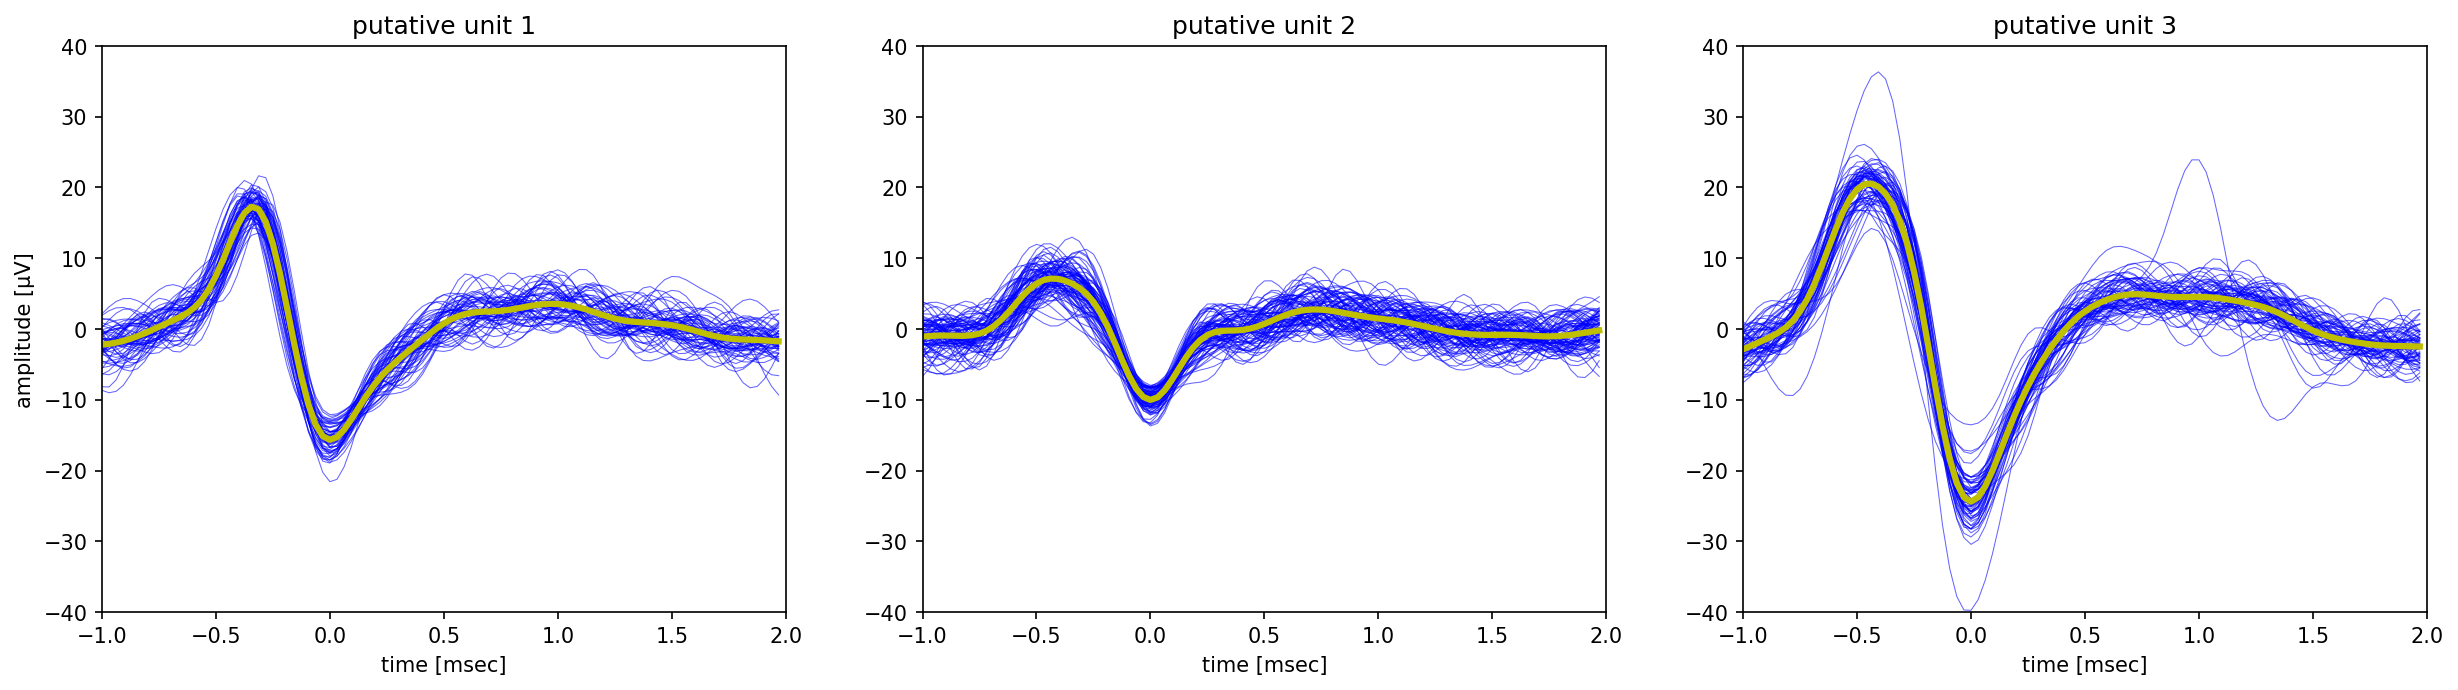

In [25]:
# visualize clustered waveforms using optimal clustering method
# let's use GaussianMixture, which seems optimal in this case
gm = GaussianMixture(n_components=n_clusters, random_state=0).fit(res_pca)
labels = gm.predict(res_pca)

fig, axes = plt.subplots(1, n_clusters, figsize=(20, 5), dpi=150)
x = np.arange(-1 * fs / 1000, 2 * fs / 1000) / (fs / 1000)

for ax, i in zip(axes, range(n_clusters)):
    idx = (labels == i)
    ax.set_title('putative unit {}'.format(i+1))
    for spike_waveform in spike_waveforms[idx]:
        ax.plot(x, spike_waveform, color='b', alpha=0.6, linewidth=0.5)
    ax.plot(x, np.average(spike_waveforms[idx], axis=0), color='y', linewidth=3.0)
    ax.set_xlim(-1, 2)
    ax.set_ylim(-40, 40)
    ax.set_xlabel('time [msec]')
    
axes[0].set_ylabel('amplitude [μV]')
plt.show()

### 4.2 sorting with multiple channels

now, let's utilize neiboring electrodes as well in order to enrich the features and improve the clustering precision.

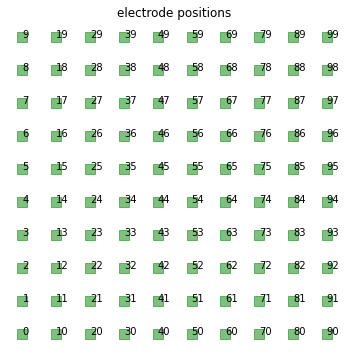

In [26]:
xs, ys = recgen.channel_positions[:, 1], recgen.channel_positions[:, 2]

fig, ax = plt.subplots(figsize=(6, 6))
ax.set_title('electrode positions')
ax.scatter(xs, ys, marker="s", c="g", s=100, alpha=0.5)

for i, (x, y) in enumerate(zip(xs, ys)):
    ax.annotate(i, (x, y))
    
ax.axis('off')
plt.show()

In [27]:
channels = [0, 1, 2, 10, 11, 12, 20, 21, 22]  # neiboring electrodes
sig = recgen.recordings[:, channels].T  # now sig is multi-dimentional
sig_filt = sig_filter(data=sig, fs=fs, lowcut=300, highcut=5000, zero_phase=True)
sig_av = np.average(sig_filt, axis=0)

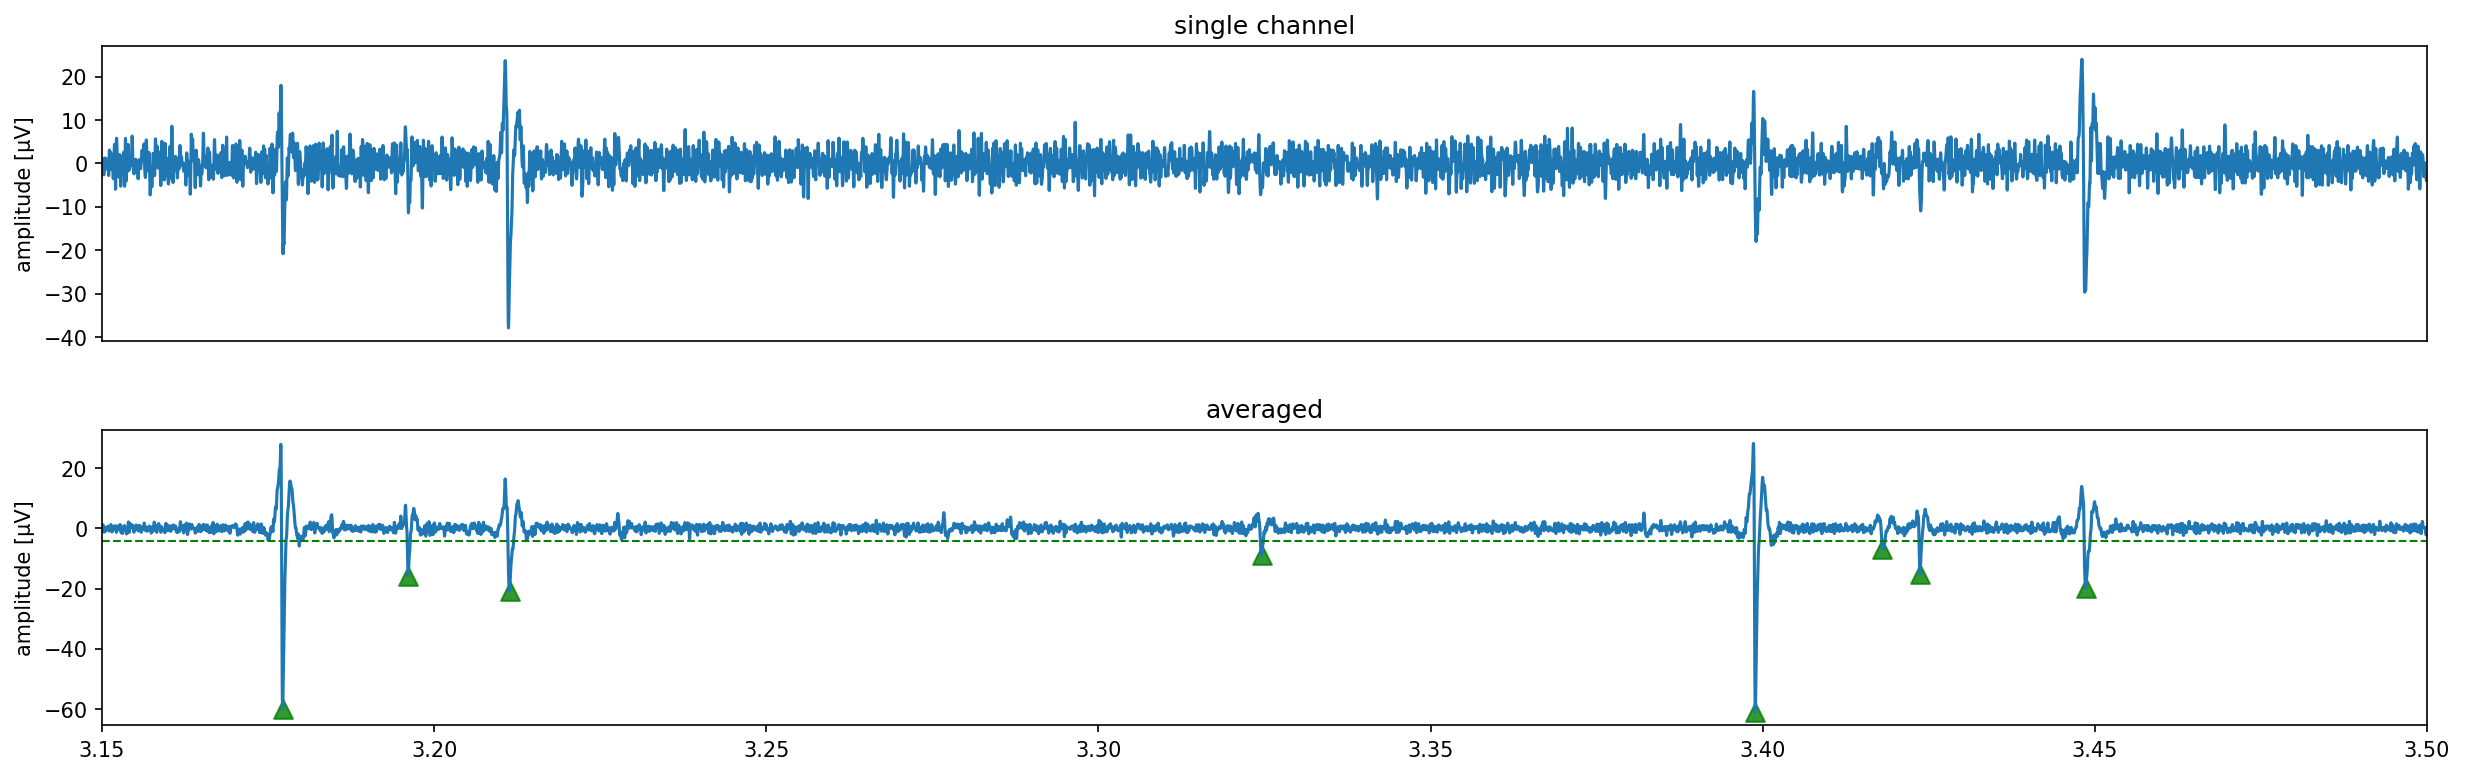

In [28]:
start, end = 3.15, 3.50
x = np.arange(fs * start, fs * end).astype(int)  # data range
plt.figure(figsize=(20, 6), dpi=150)

# plot 1
ax1 = plt.subplot(2, 1, 1)
ax1 = plot_sig(ax=ax1, sig=sig_filt[0], start=start, end=end, title='single channel', ylabel='amplitude [μV]')
ax1.set_xticks([])

# plot 2
ax2 = plt.subplot(2, 1, 2)
ax2 = plot_sig(ax=ax2, sig=sig_av, start=start, end=end, title='averaged', ylabel='amplitude [μV]')

## plot peaks and thresholds
n_mad = 6
thr_mad = stats.median_abs_deviation(sig_av) * n_mad
peaks = peak_detection(sig=sig_av[x], thr=thr_mad)

ax2.scatter(x=x[peaks] / fs, y=sig_av[x][peaks], s=80, alpha=0.8, marker='^', c='green', label='{} MAD'.format(n_mad))
ax2.axhline(y=-thr_mad, xmin=0.0, xmax=1.0, label='{} MAD'.format(n_mad), color='green', linestyle='dashed', linewidth=1)

# show
plt.subplots_adjust(wspace=0.4, hspace=0.3)
plt.show()

In [49]:
n_mad = 6
thr_mad = stats.median_abs_deviation(sig_av) * n_mad
peaks = peak_detection(sig=sig_av, thr=thr_mad)
spike_waveforms_concat = np.concatenate([extract_spike_waveforms(sig=sig_ch, peaks=peaks, t_pre=1, t_post=2) for sig_ch in sig_filt], axis=1)

In [50]:
pca = PCA(n_components=2, random_state=0)
pca.fit(spike_waveforms_concat.T)
res_pca = pca.components_.T

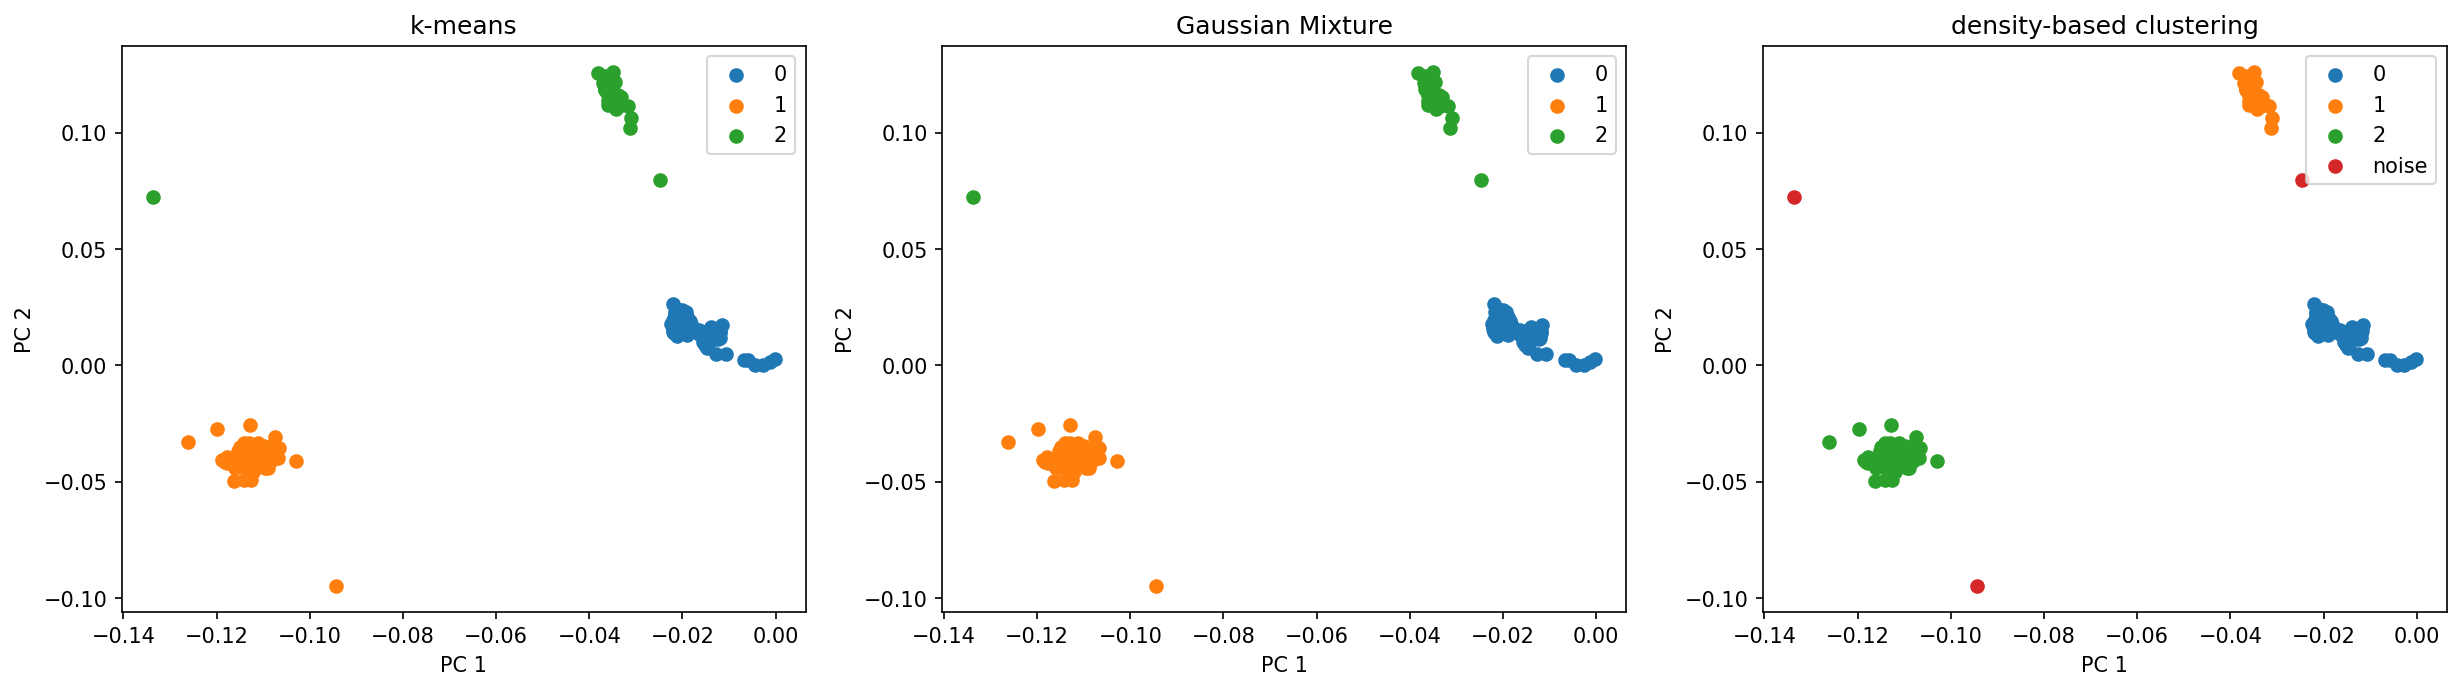

In [51]:
n_clusters = 3
fig, axes = plt.subplots(1, 3, figsize=(20, 5), dpi=150)

# k-means
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(res_pca)
labels = kmeans.labels_

for i in range(n_clusters):
    idx = (labels == i)
    axes[0].scatter(x=res_pca[:, 0][idx], y=res_pca[:, 1][idx], label=i)

axes[0].set_title('k-means')
axes[0].set_xlabel('PC 1')
axes[0].set_ylabel('PC 2')
axes[0].legend()

# Gausian Mixture
gm = GaussianMixture(n_components=n_clusters, random_state=0).fit(res_pca)
labels = gm.predict(res_pca)

for i in range(n_clusters):
    idx = (labels == i)
    axes[1].scatter(x=res_pca[:, 0][idx], y=res_pca[:, 1][idx], label=i)

axes[1].set_title('Gaussian Mixture')
axes[1].set_xlabel('PC 1')
axes[1].set_ylabel('PC 2')
axes[1].legend()

# density-based clustering
clustering = DBSCAN(eps=0.01, min_samples=5).fit(res_pca)
labels = clustering.labels_
n_clusters = np.max(labels) + 1

for i in range(n_clusters):
    idx = (labels == i)
    axes[2].scatter(x=res_pca[:, 0][idx], y=res_pca[:, 1][idx], label=i)

# in DBSCAN, outliers are labeled as -1
idx = labels == -1
axes[2].scatter(x=res_pca[:, 0][idx], y=res_pca[:, 1][idx], label='noise')

axes[2].set_title('density-based clustering')
axes[2].set_xlabel('PC 1')
axes[2].set_ylabel('PC 2')
axes[2].legend()

plt.show()

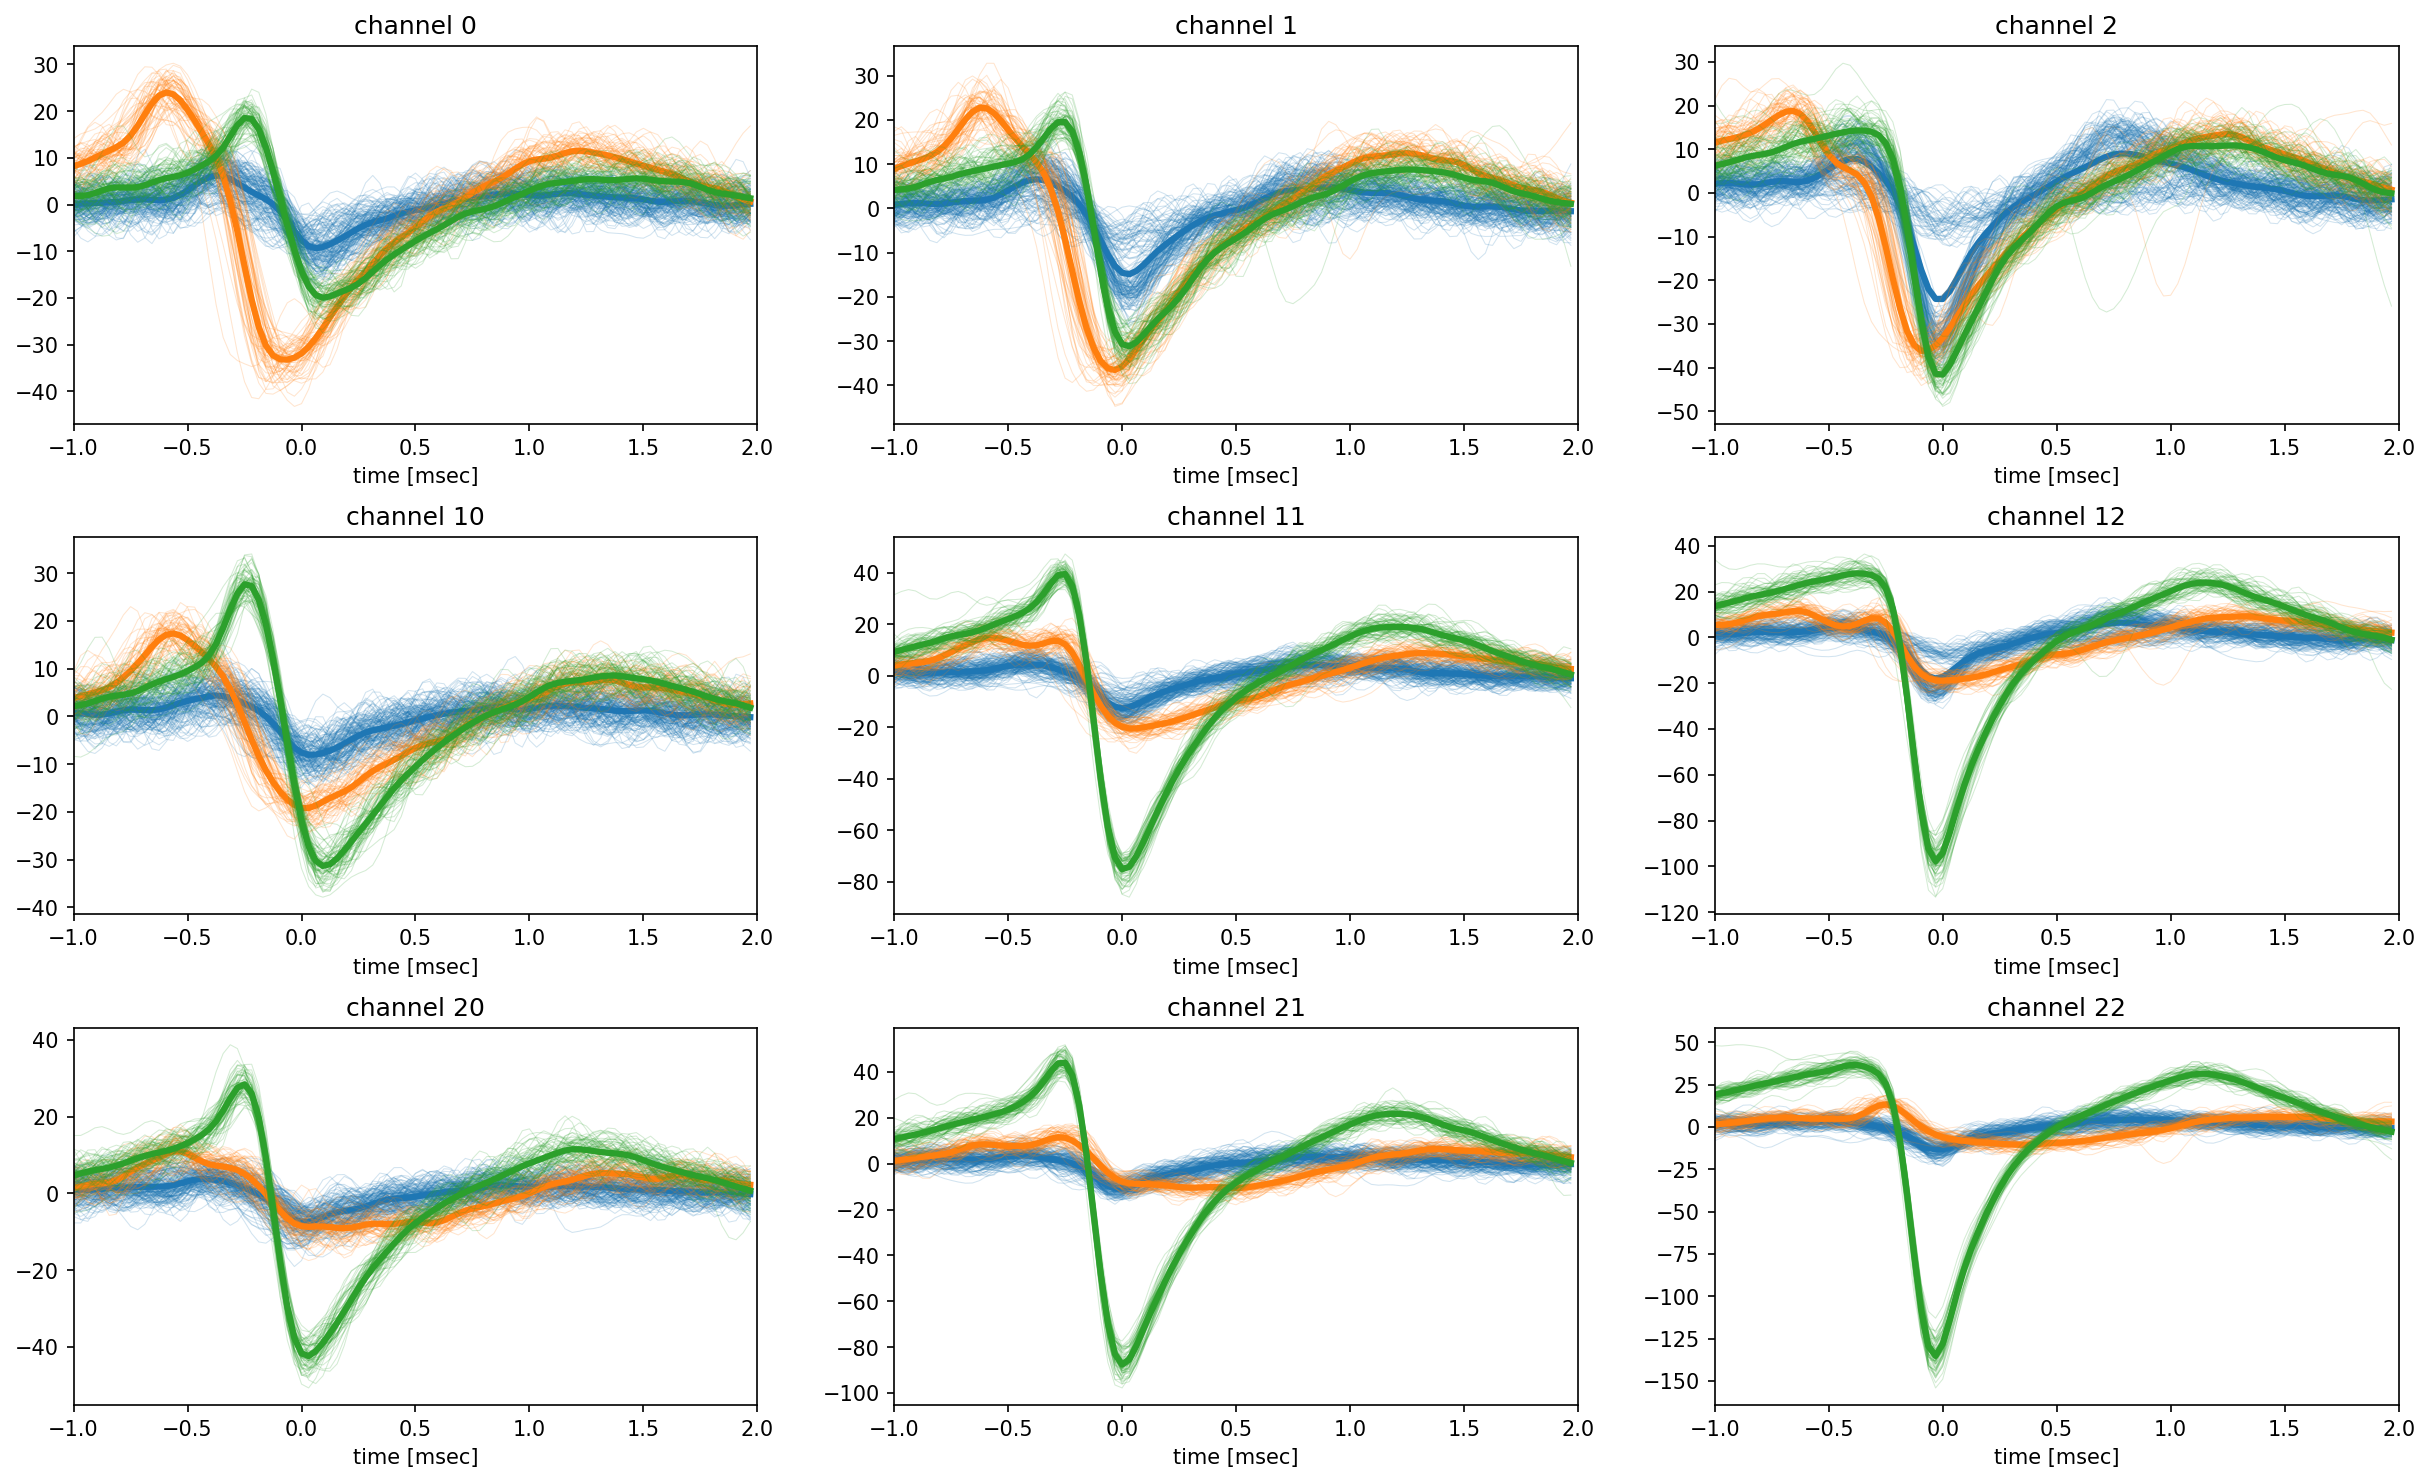

In [52]:
spike_waveforms_each = spike_waveforms_concat.reshape(len(spike_waveforms_concat), len(channels), -1)

# refer to density-based clustering
clustering = DBSCAN(eps=0.01, min_samples=5).fit(res_pca)
labels = clustering.labels_
n_clusters = np.max(labels) + 1

# plot
fig, axes = plt.subplots(3, 3, figsize=(20, 12), dpi=150)
x = np.arange(-1 * fs / 1000, 2 * fs / 1000) / (fs / 1000)
colors = ['tab:blue', 'tab:orange', 'tab:green']

for i, channel in enumerate(channels):
    ax = axes[i // 3, i % 3]
    ax.set_title('channel {}'.format(channel))
    
    for k in range(n_clusters):
        idx = (labels == k)
        for spike_waveform in spike_waveforms_each[idx, i, :]:
            ax.plot(x, spike_waveform, color=colors[k], alpha=0.2, linewidth=0.5, label='putative unit {}'.format(k))
        ax.plot(x, np.average(spike_waveforms_each[idx, i, :], axis=0), color=colors[k], linewidth=3.0)
        
    ax.set_xlim(-1, 2)
    ax.set_xlabel('time [msec]')

# show
plt.subplots_adjust(wspace=0.2, hspace=0.3)
plt.show()